In [33]:
import os
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.datasets.folder import default_loader
from torchvision import transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import time

In [3]:
batch_size = 32


train_dir = "/home/dawlat.akaila/Documents/AI_LABS/PROJECT_FINAL/datasets/chest_xray/train"
val_dir = "/home/dawlat.akaila/Documents/AI_LABS/PROJECT_FINAL/datasets/chest_xray/val"
test_dir = "/home/dawlat.akaila/Documents/AI_LABS/PROJECT_FINAL/datasets/chest_xray/test"

transform = transforms.Compose(
                [
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                ]
            )

train_data = ImageFolder(train_dir, transform=transform, loader=default_loader)
val_data = ImageFolder(val_dir, transform=transform, loader=default_loader)
test_data = ImageFolder(test_dir, transform=transform, loader=default_loader)

image_datasets = {'train': train_data, 'validation': val_data}


In [4]:
def START_seed():
    seed = 9
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [5]:
# load dataset
START_seed()
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers = 8)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True, num_workers = 8)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers = 8)

dataloaders = {
    'train': train_loader, 
    'validation':val_loader
}

images.shape: torch.Size([32, 3, 224, 224])


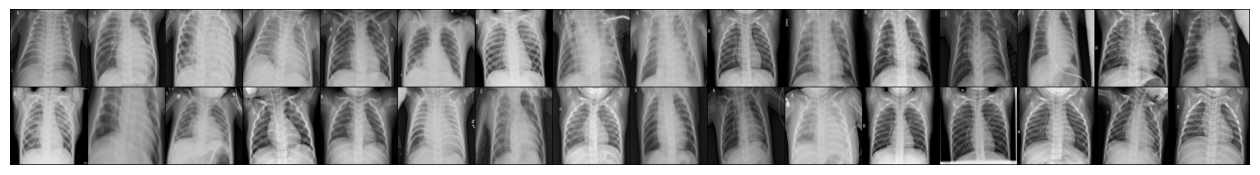

In [6]:

for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [7]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model = model.to(device=device) 

for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.Dropout(0.3),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

# Number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

23770562


In [8]:
# Loss and optimizer
lr=1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr= lr) 

In [38]:
def train_model(model, criterion, optimizer, num_epochs=3):
    start_time = time.time()
    train_losses_per_epochs = []
    val_losses_per_epochs = []
    train_acc_per_epochs = []
    val_acc_per_epochs = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_losses_per_epochs.append(epoch_loss)
                train_acc_per_epochs.append(epoch_acc.item())
            else:
                val_losses_per_epochs.append(epoch_loss)
                val_acc_per_epochs.append(epoch_acc.item())

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    print("Time:", (time.time() - start_time))
    return model, train_losses_per_epochs, val_losses_per_epochs, train_acc_per_epochs, val_acc_per_epochs

In [39]:
model_trained, train_losses_per_epochs, val_losses_per_epochs, train_acc_per_epochs, val_acc_per_epochs = train_model(model, criterion, optimizer, num_epochs=40)

Epoch 1/1
----------
train loss: 0.0952, acc: 0.9670
validation loss: 1.1326, acc: 0.5625
Time: 15.174147844314575


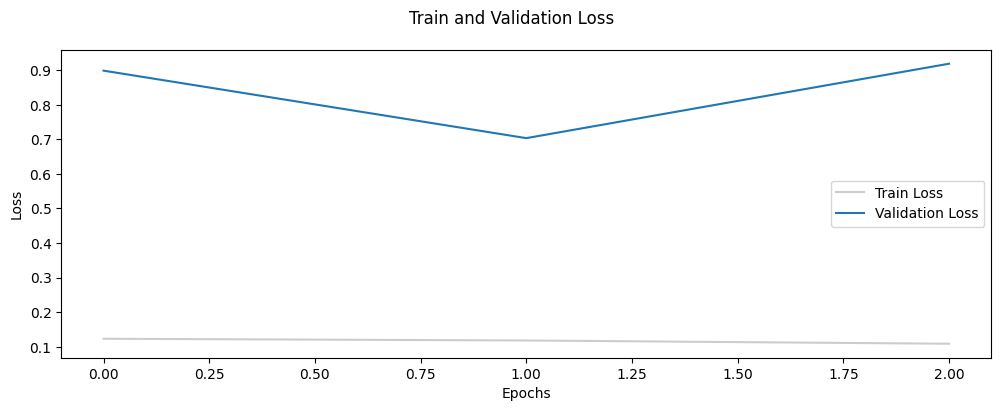

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Train and Validation Loss")
ax.plot(
    train_losses_per_epochs,
    alpha=0.2,
    label="Train Loss",
    color="black",
)
ax.plot(val_losses_per_epochs, label="Validation Loss")


# Set x-label and y-label
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
fig.savefig("Train_and_Validation_Loss_ResNet")

_ = ax.legend()

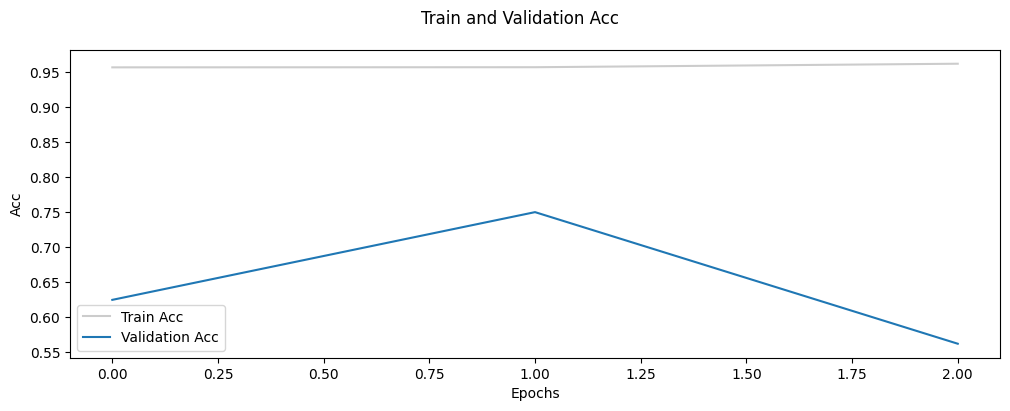

In [32]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Train and Validation Acc")
ax.plot(
    train_acc_per_epochs,
    alpha=0.2,
    label="Train Acc",
    color="black",
)
ax.plot(val_acc_per_epochs, label="Validation Acc")


# Set x-label and y-label
ax.set_xlabel("Epochs")
ax.set_ylabel("Acc")
fig.savefig("Train_and_Validation_Acc_ResNet")

_ = ax.legend()

In [11]:
from torchvision.models import swin_v2_b, Swin_V2_B_Weights

model_s = swin_v2_b(weights=Swin_V2_B_Weights.DEFAULT)
model_s = model_s.to(device=device) 

for param in model_s.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model_s.head.in_features
model_s.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 2)
)
model_s = model_s.to(device)

# Number of parameters
total_params = sum(p.numel() for p in model_s.parameters())
print(total_params)

KeyboardInterrupt: 

In [ ]:
optimizer_s = torch.optim.Adam(model_s.head.parameters(), lr= lr) 

In [ ]:
model_s_trained, train_losses_per_epochs, val_losses_per_epochs, train_acc_per_epochs, val_acc_per_epochs = train_model(model_s, criterion, optimizer_s, num_epochs=40)

Epoch 1/3
----------
train loss: 0.3581, acc: 0.8441
validation loss: 0.6003, acc: 0.6875
Epoch 2/3
----------
train loss: 0.1910, acc: 0.9291
validation loss: 0.7022, acc: 0.6250
Epoch 3/3
----------
train loss: 0.1676, acc: 0.9362
validation loss: 0.7882, acc: 0.6250


In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Train and Validation Loss")
ax.plot(
    train_losses_per_epochs,
    alpha=0.2,
    label="Train Loss",
    color="black",
)
ax.plot(val_losses_per_epochs, label="Validation Loss")


# Set x-label and y-label
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
fig.savefig("Train_and_Validation_Loss_Swin")

_ = ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Train and Validation Acc")
ax.plot(
    train_acc_per_epochs,
    alpha=0.2,
    label="Train Acc",
    color="black",
)
ax.plot(val_acc_per_epochs, label="Validation Acc")


# Set x-label and y-label
ax.set_xlabel("Epochs")
ax.set_ylabel("Acc")
fig.savefig("Train_and_Validation_Acc_Swin")

_ = ax.legend()